# Sentiment Analysis of IMDB Review 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils import get_imdb_dataset, load_glove_vecs

## Dataset

In [2]:
# Load dataset
train, test = get_imdb_dataset()
#train = pd.read_csv("./data/imdb/train.csv")
#test  = pd.read_csv("./data/imdb/test.csv")

In [3]:
pd.set_option('max_colwidth', 500)

In [4]:
# show a random subset of the data
train.sample(5)

,text,sentiment
22279,"I watched this movie at a Sneak Preview screening and I'm glad I didn't pay for it. This movie is just disgusting. Its full of dick and fart jokes and takes no pride in the action sequences(such as the shootout in ""Little Germany""). I made a little list of things I enjoyed in the movie.. and a lot of which I didn't agree of.<br /><br />1. Dave Foley's penis. 2. The fart jokes. 3. The Poop jokes. 4. The Dude was a pussy. 5. No Gary Coleman. 6. The Talibans 7. Again making fun of Bush.. WE GET...",neg
6732,"""A Cry in the Dark"" is a masterful piece of cinema, haunting, and incredibly though provoking. The true story of Lindy Chamberland, who, in 1980, witnessed a horrific sight, seeing her 3-month-old baby being brutally taken from their family's tent, while camping on the Austrailian outback. Azaria (the baby) was never seen again, and the result of her horrendous disappearance caused a true life frenzy all around the world. Meryl Streep does immaculate justice to the role of Lindy, as she alwa...",pos
23366,"I was babysitting a family of three small children for a night and their mother gave me this to show for them having just grabbed it at Wal-Mart earlier in the week. All three children actually got physically ill while watching it. I'm pretty sure it was the pizza they ate, or something they all had picked up from school, but really it could have been this film. Absolutely disgusting. How any one can produce this caliber of trash is beyond me. Fortunately, I turned off the film when I notice...",neg
12179,"I've been impressed with Chavez's stance against globalisation for sometime now, but it wasn't until I saw the film at the Amsterdam documentary international film festival that I realize what he has really achieved. This film tells the story of coup/conspiracy by Venezuela's elite, the oil companies and oil loving corrupt western governments, to remove democratically elected president Chavez, and return Venezuela back to a brutal dictatorship. This film is must for anyone who believes in fr...",pos
8462,"The film largely focuses on a bullying Robert Taylor as a ruthless buffalo hunter and the people who have to put up with him. Set amidst a hunt for dwindling numbers of buffalo, it portrays the end of a tragic era of senseless slaughter and is full of drama and remorse for both the buffalo and the Native Americans. Taylor is blinded by his hatred of Indians and his naivete that the buffalo herds will never disappear. In one scene, he shoots animal after animal, while in another he murders In...",pos


In [5]:
print('train shape:', train.shape)
print('test  shape:', test.shape)

train shape: (25000, 2)
test  shape: (25000, 2)


In [6]:
# Statics on lables
train['sentiment'].value_counts()

pos    12500
neg    12500
Name: sentiment, dtype: int64

## Preprocessing Pipline

### Tokenization and Normalization (Lemmatization)

In [7]:
import nltk
import string

In [8]:
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation)) # Remove punctuations (replace with whitespace)
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

In [9]:
#stopwords[:100]

In [10]:
#string.punctuation

In [11]:
def preprocessing(line: str) -> str:
    """
    Take a text input and return the preprocessed string.
    i.e.: preprocessed tokens concatenated by whitespace
    """
    line = line.replace('<br />', '').translate(transtbl) 
    
    # list
    tokens = [lemmatizer.lemmatize(t.lower(),'v')
              for t in nltk.word_tokenize(line)
              if t.lower() not in stopwords]
    
    return ' '.join(tokens)

### Multi-threads processing

In [12]:
import dask.dataframe as dd
from dask.multiprocessing import get

In [13]:
%%time
for df in train, test:
    ddf = dd.from_pandas(df, npartitions=48)
    df['text_prep'] = ddf.map_partitions(lambda d: d.apply((lambda row: preprocessing(row['text'])), axis=1)).compute(scheduler='processes') 

CPU times: user 1.74 s, sys: 515 ms, total: 2.26 s
Wall time: 31.4 s


In [14]:
assert train.shape == (25000, 3)
assert test.shape == (25000, 3)

In [15]:
train.sample(5)

,text,sentiment,text_prep
11784,"This was different, that's for sure. Just look at the cast! Talk about oddballs.<br /><br />William H. Macy and Ben Stiller were the stars, although a bunch of actors almost share the spotlight, in this farce about superhero-wannabees. The most outrageous was played by Paul Reubens of ""Pee Wee Herman"" fame.<br /><br />There is lots of humor, garish colors and no lulls. It's a pretty entertaining, lightweight comedy with nothing but goofy characters, all of whom want to be heroes a la Superma...",pos,different sure look cast talk oddballs william h macy ben stiller star although bunch actors almost share spotlight farce superhero wannabees outrageous play paul reubens pee wee herman fame lot humor garish color lull pretty entertain lightweight comedy nothing goofy character want heroes la superman batman spiderman name talents strange areas however real heroes want silly know go also film watch installments really miss continuity long movie one hectic take break okay language tame kid co...
3448,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry for five minutes with emotive music and the odd suicide. <br /><br />I do not believe that turning thi...",pos,child sexploitation one serious issue face world today fear film topic would jump straight scenes explicitly sexual nature order shock disturb audience see trade holly one film move want actually see change international laws felt like poor attempt make cry five minutes emotive music odd suicide believe turn issue hollywood tear jerker useful necessary strategy adopt must commend make holly engage subtly powerfully terrible condition children sadly force endure trade waver serious stupid sce...
409,"I believe this is the most powerful film HBO Pictures has made to date. This film should have been released in theaters for the public to view on the big screen. It is available on video so make sure you look for it and check it out. Chris Gerolmo did a great job with the direction and the screenplay. The performances from Stephen Rea, Donald Sutherland and Jeffery DeMunn are flawless. A masterpiece of the genre.",pos,believe powerful film hbo picture make date film release theaters public view big screen available video make sure look check chris gerolmo great job direction screenplay performances stephen rea donald sutherland jeffery demunn flawless masterpiece genre
13427,"SPOILERS AHEAD<br /><br />This is one of the worst movies ever made - it's that simple. There is not one redeeming quality about this movie. The first 10 minutes are quite tricky - they actually lead you to believe that this film will be shocking and will have you on the edge of your seat. Instead, you will spend 83 minutes punching yourself while watching stolen and poorly made scenes run without any organization. The lake was ridiculous, looked like an aquarium, and had the same plant in d...",neg,spoilers aheadthis one worst movies ever make simple one redeem quality movie first 10 minutes quite tricky actually lead believe film shock edge seat instead spend 83 minutes punch watch steal poorly make scenes run without organization lake ridiculous look like aquarium plant different part lake bed character show advance teleportation power example alex thomas fall lake drink end boat impossible position angie harmon put pitiful performance kate make worse space time continuum rupture dia...
17193,"I ve finished seeing the movie 10 minutes ago..WoW i still cant believe what i've watched.<br /><br />This is absolutely the worst movie EVER. If i would list all the flaws in the movie , this review would take me a lot of sentences.( very funny f

### Build Vocabulary
We can only use words in training data for building vocabulary

In [17]:
from tqdm.auto import tqdm
tqdm.pandas()

In [18]:
all_words = [w for text in tqdm(train['text_prep']) 
             for w in text.split()]

100%|██████████| 25000/25000 [00:00<00:00, 65137.44it/s]


In [19]:
# Use FreqDist to get count for each word
voca = nltk.FreqDist(all_words)
print(voca)

<FreqDist with 65102 samples and 3025774 outcomes>


In [52]:
topwords = [word for word, _ in voca.most_common(20000)]

In [53]:
most_commmom_wordList = []
most_commmom_CountList = []
for x, y in voca.most_common():
    most_commmom_wordList.append(x)
    most_commmom_CountList.append(y)

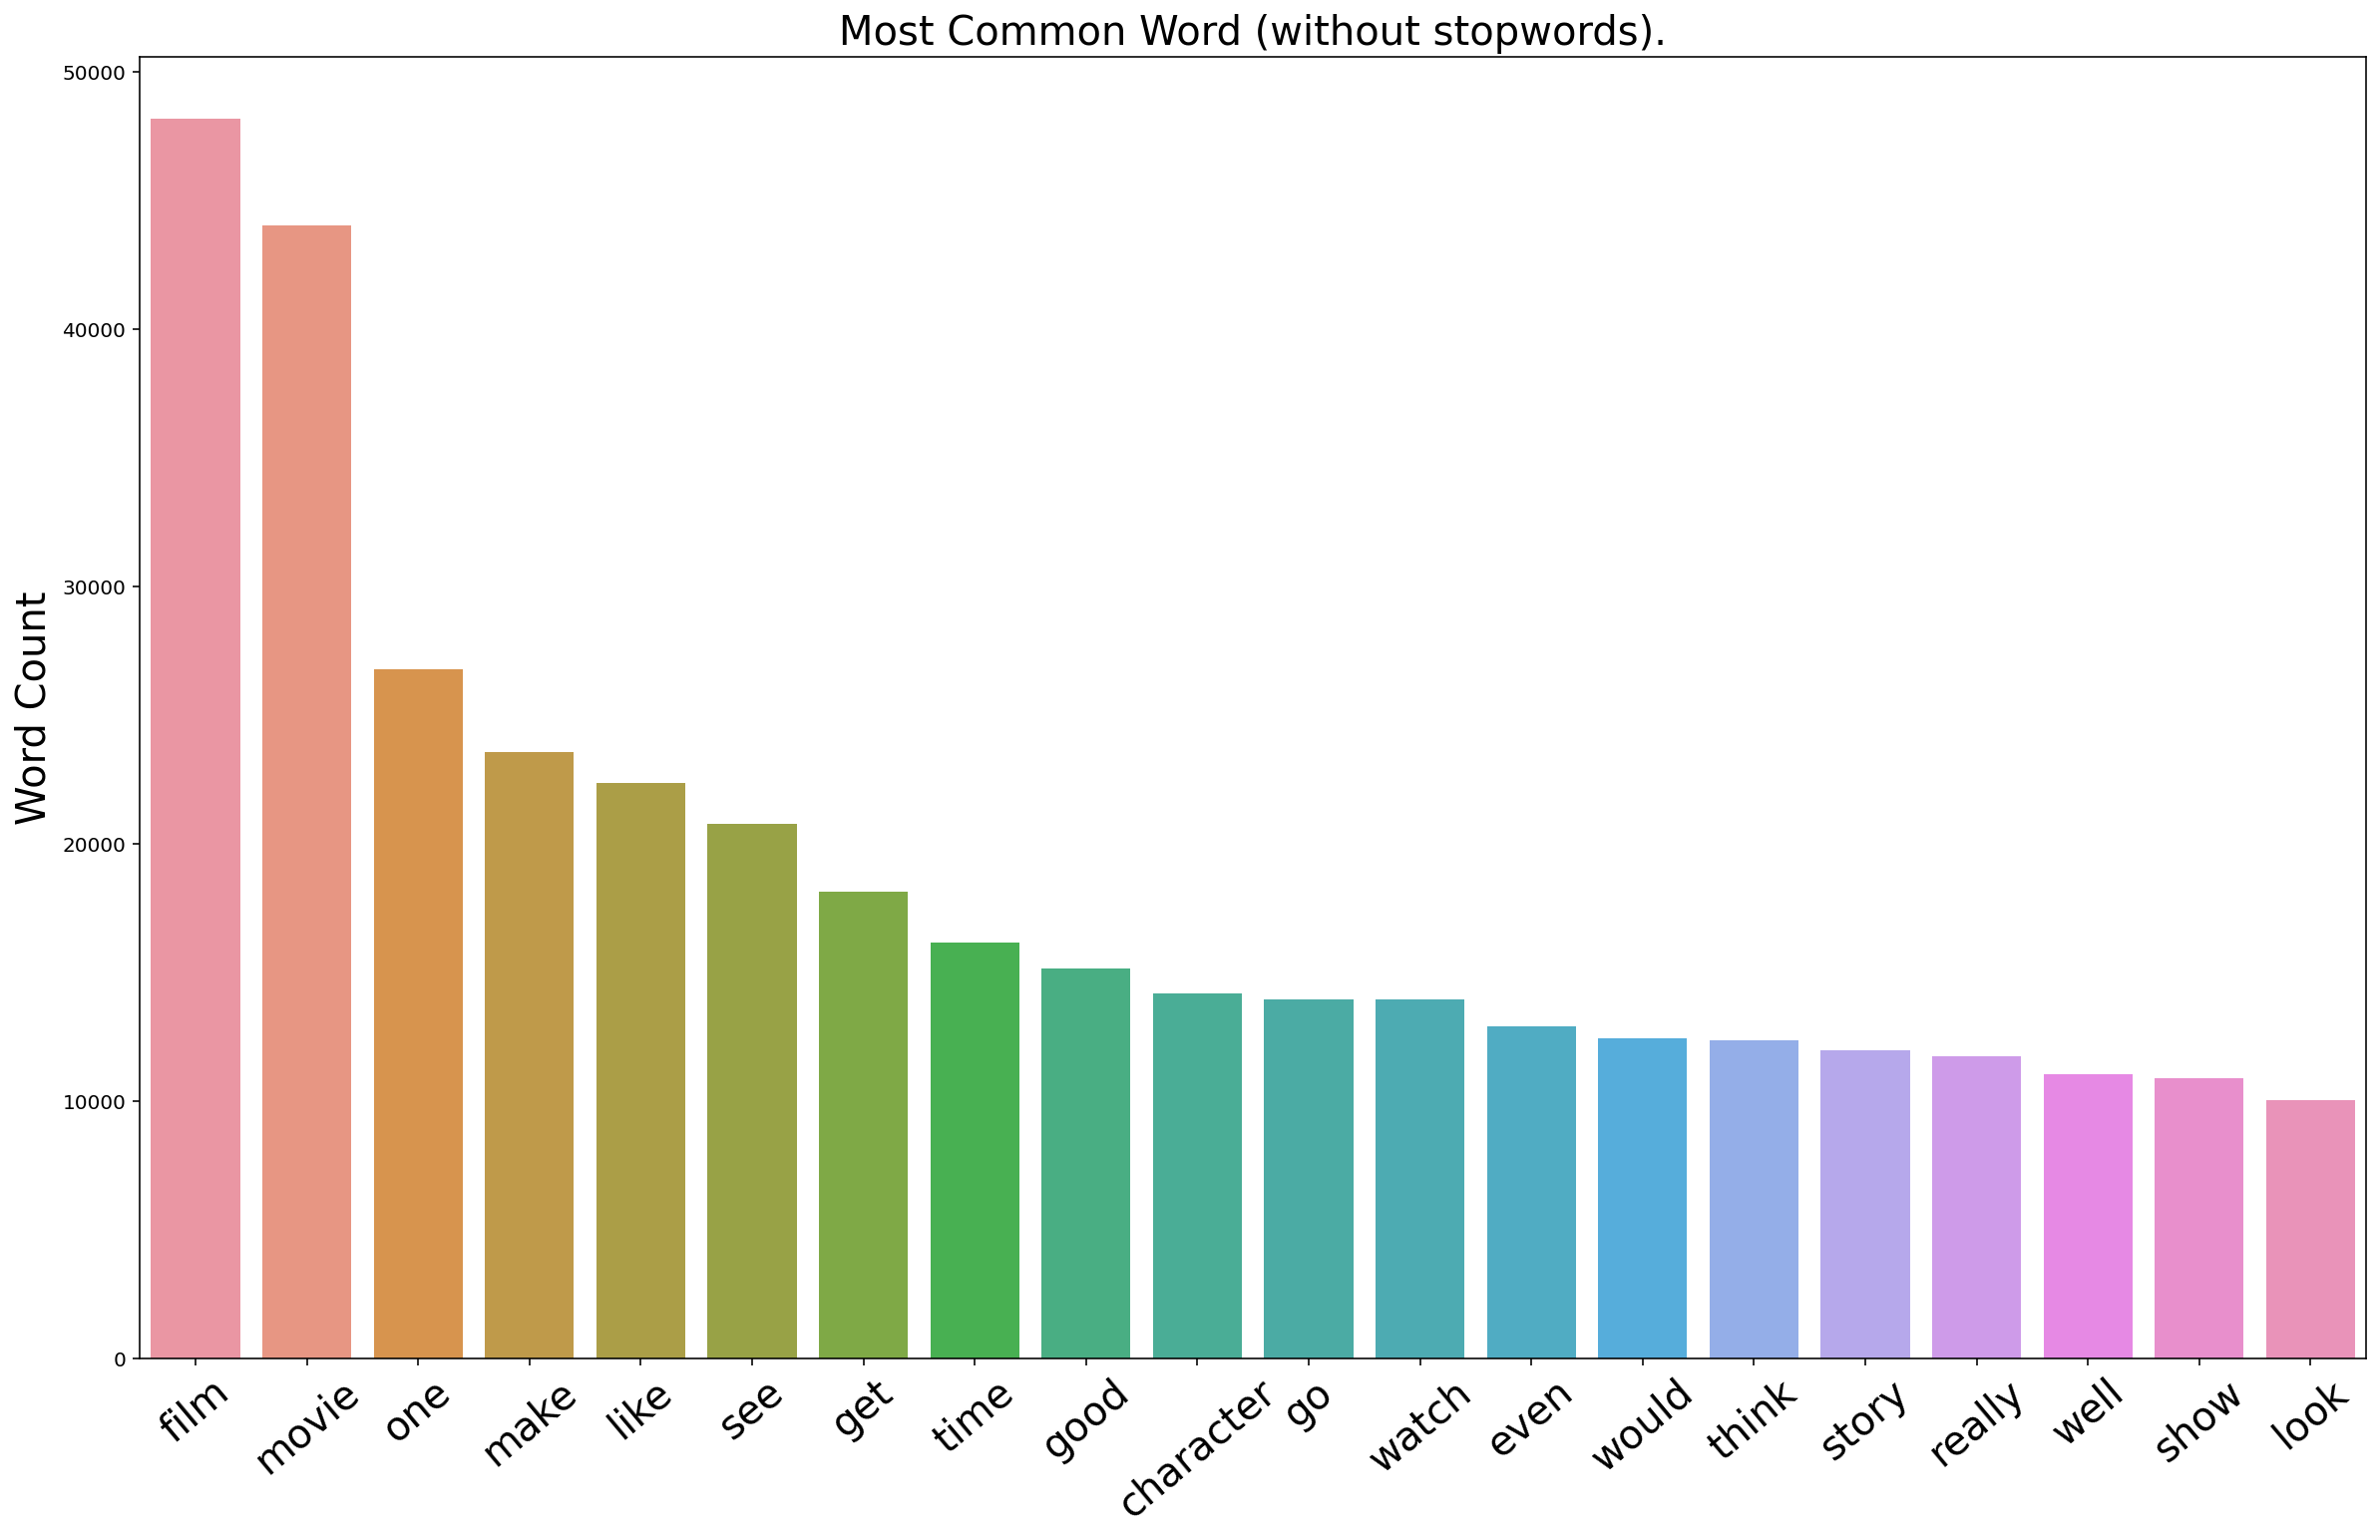

In [54]:
import seaborn as sns
plt.figure(figsize=(20,12))
plot = sns.barplot(np.arange(20), most_commmom_CountList[0:20])
plt.ylabel('Word Count',fontsize=20)
plt.xticks(np.arange(20), most_commmom_wordList[0:20], fontsize=20, rotation=40)
plt.title('Most Common Word (without stopwords).', fontsize=20)
plt.show()

### Vectorizer

For this section, we will try two ways to do vectorization: **BoW** (1-gram) and **BoW with Tfidf Transformer**.

In [55]:
from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer,)

### Vectorization / Featurization

In [56]:
train_x, train_y = train['text_prep'], train['sentiment']
test_x, test_y = test['text_prep'], test['sentiment']

In [57]:
# Use topwords as vocabulary
tf_vec = TfidfVectorizer(vocabulary=topwords, ngram_range=(1,3))

In [58]:
train_features = tf_vec.fit_transform(train_x)
test_features = tf_vec.transform(test_x)

In [59]:
assert train_features.shape == (25000, 20000)
assert test_features.shape == (25000, 20000)

In [60]:
train_features[0][:50].toarray()

array([[0.      , 0.103707, 0.      , ..., 0.      , 0.      , 0.      ]])

In [61]:
train_y_id = np.array([1 if label == 'pos' else 0 for label in train_y])
test_y_id = np.array([1 if label == 'pos' else 0 for label in test_y])

## Training

### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and logistic regression

In [62]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [63]:
mnb_model = MultinomialNB()

In [64]:
%%time
# Train Model
mnb_model.fit(train_features, train_y_id)

CPU times: user 16.1 ms, sys: 3.39 ms, total: 19.5 ms
Wall time: 18.2 ms


MultinomialNB()

## Evaluation

In [65]:
from sklearn import metrics

In [66]:
# Predict on test set
pred = mnb_model.predict(test_features)

In [67]:
print('Accuracy: %f' % metrics.accuracy_score(pred,test_y_id))

Accuracy: 0.827880


<span style="color:red">**Tips:**</span>: pass ytest and ypred in the correct order when you need to calculate per-class metrics like f-score.

In [68]:
# Pass in as keyword arguments to make sure the order is correct
print(metrics.classification_report(y_true=test_y_id, y_pred=pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12500
           1       0.86      0.78      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



## Tunning hyper parameters

In [69]:
def train_with_n_topwords(n: int, tfidf=False, method="nb") -> tuple:
    """
    Train and get the accuracy with different model settings
    Args:
        n: number of features (top frequent words in the vocabulary)
        tfidf: whether do tf-idf re-weighting or not
    Outputs:
        tuple: (accuracy score, classifier, vectorizer)
    """
    topwords = [word for word, _ in voca.most_common(n)]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(train_x)
    test_features  = vec.transform(test_x)
    
    if method=="logistic":
        model = LogisticRegression()
    else:
        model = MultinomialNB()
    
    model.fit(train_features, train_y_id)
    
    # Test predict
    pred = model.predict(test_features)
    
    return metrics.accuracy_score(pred, test_y_id), model, vec

In [70]:
topN = [500 * i for i in range(1, 40)]

cnt_accuracies = []
tfidf_accuracies = []

for n in tqdm(topN):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])

100%|██████████| 39/39 [05:06<00:00,  7.86s/it]


Text(0, 0.5, 'accuracy')

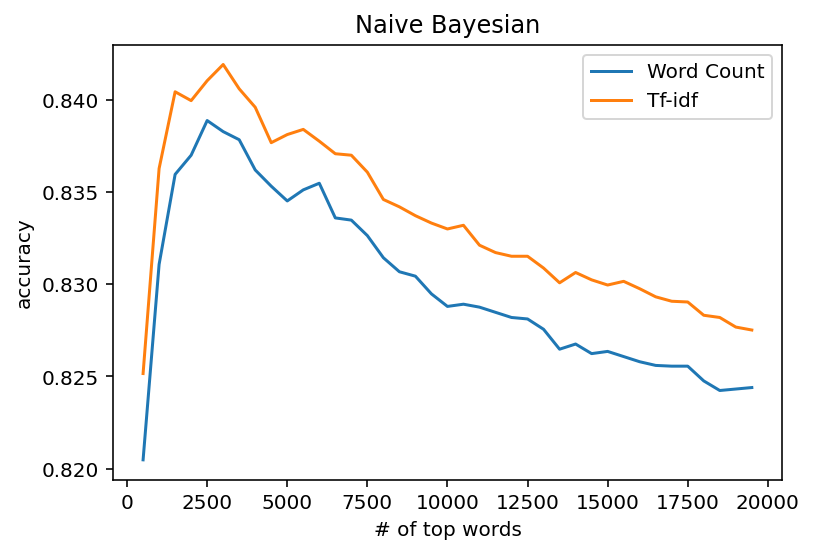

In [71]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(topN, cnt_accuracies, label='Word Count')
plt.plot(topN, tfidf_accuracies, label='Tf-idf')
plt.legend()
plt.title("Naive Bayesian")
plt.xlabel("# of top words")
plt.ylabel("accuracy")

### <span style="color:green">**Logistic Regression:**</span> 

In [72]:
topN = [500 * i for i in range(1, 40)]
cnt_accuracies = []
tfidf_accuracies = []

for n in tqdm(topN):
    cnt_accuracies.append(train_with_n_topwords(n, method="logistic")[0])
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True, method="logistic")[0])

100%|██████████| 39/39 [05:40<00:00,  8.73s/it]


Text(0, 0.5, 'accuracy')

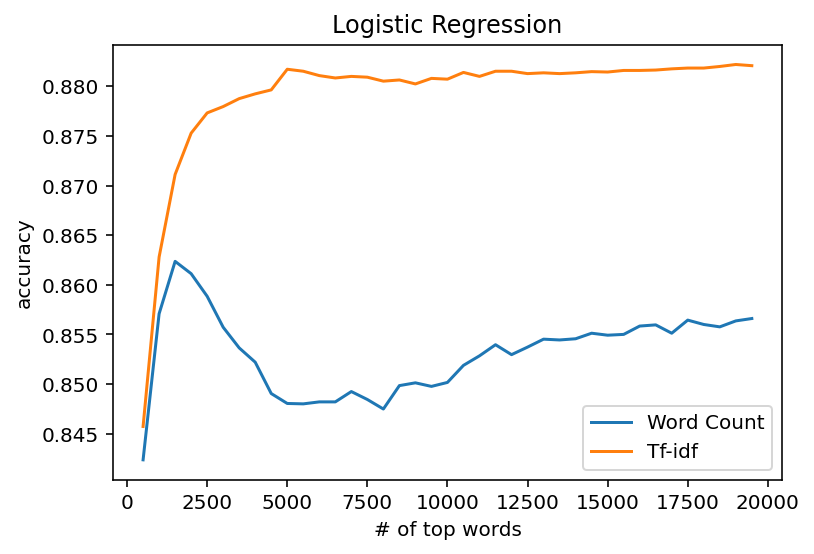

In [73]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(topN, cnt_accuracies, label='Word Count')
plt.plot(topN, tfidf_accuracies, label='Tf-idf')
plt.legend()
plt.title("Logistic Regression")
plt.xlabel("# of top words")
plt.ylabel("accuracy")